# Comparison to SQD with N2

## Setup

In [ ]:
#!pip install qiskit-addon-sqd ffsim pyscf openfermion openfermionpyscf quimb[tensor] ply joblib --quiet

In [2]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np

import pyscf
import pyscf.cc
import pyscf.mcscf

import openfermion as of
from openfermionpyscf import run_pyscf

import cirq
import qiskit

import quimb
import quimb.tensor as qtn

import ffsim

In [3]:
# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()

geometry = [["N", (0, 0, 0)], ["N", (1.0, 0, 0)]]
mol.build(
    atom=geometry,
    basis="6-31g",
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2

cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy
exact_energy = cas.run().e_tot

converged SCF energy = -108.835236570774
CASCI E = -109.046671778080  E(CI) = -32.8155692383188  S^2 = 0.0000000


## Convert to/construct OpenFermion Hamiltonian

In [4]:
charge = mol.charge
multiplicity = mol.multiplicity
basis = mol.basis
# geometry = geometry_from_pubchem("n2")

ofham = of.MolecularData(geometry, basis, charge=0, multiplicity=1)
ofmol = run_pyscf(ofham, run_mp2=True, run_cisd=False, run_ccsd=False, run_fci=False)

ham = of.MolecularData(filename=ofmol.filename)
ham = ham.get_molecular_hamiltonian()
ham = of.get_fermion_operator(ham)
ham = of.transforms.freeze_orbitals(ham, occupied=[0, 1, 2, 3])
ham = of.jordan_wigner(ham)
ham.compress(abs_tol=1e-2)

In [5]:
nqubits = of.utils.count_qubits(ham)
nterms = len(ham.terms)
print(f"Qubit Hamiltonian acts on {nqubits} qubit(s) and has {nterms} term(s).")

Qubit Hamiltonian acts on 32 qubit(s) and has 3449 term(s).


## Ansatz circuit

In [6]:
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -109.0398256929733  E_corr = -0.2045891221988308


In [7]:
n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = qiskit.QuantumRegister(2 * num_orbitals, name="q")
circuit = qiskit.QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
# circuit.measure_all()
# circuit.draw(fold=-1)

In [8]:
compiled = qiskit.transpile(circuit, basis_gates=["u3", "cx"], optimization_level=3)
compiled.count_ops()

OrderedDict([('u3', 2624), ('cx', 1348)])

In [10]:
import qiskit.qasm2

from cirq.contrib.qasm_import import circuit_from_qasm


circuit_cirq = circuit_from_qasm(qiskit.qasm2.dumps(compiled))

In [12]:
def simulate(
    circuit: cirq.Circuit,
    dtype: str = "float64",
    verbose: bool = False,
    max_bond: int = 16,
    ) -> qtn.MatrixProductState:
    qubits_to_indices = {q: i for i, q in enumerate(sorted(circuit.all_qubits()))}
    nqubits = len(qubits_to_indices)

    mps = qtn.MPS_computational_state("0" * nqubits, dtype=dtype, cyclic=False)
    num_ops = len(list(circuit.all_operations()))
    for i, op in enumerate(circuit.all_operations()):
        mps.gate_(
            quimb.qarray(cirq.unitary(op)),
            [qubits_to_indices[q] for q in op.qubits],
            contract="swap+split",
            max_bond=max_bond,
        )
        if verbose:
            print(f"\rOp {i + 1} / {num_ops}", end="")

    return mps

In [13]:
psi = simulate(circuit_cirq, verbose=True, max_bond=64)

Op 3972 / 3972

In [14]:
psi.normalize()

0.18882247705971444

In [15]:
psi.norm()

1.0

## Sorted insertion with $k$-commuting shot counts

In [13]:
from kcommute import get_si_sets, r_hat_measurement_count
from kcommute.commute import compute_blocks
from kcommute.shot_metrics import get_shotcounts_mpo_mps
from kcommute.tensor_nets import groups_of_to_mpos

In [14]:
qubits = cirq.LineQubit.range(nqubits)
kvals = [1, 8, 16, 24, 32]

In [15]:
all_groups = []
all_ngroups = []
all_rhats = []
all_shots = []

for k in kvals:
    print(f"Status: on k = {k}")
    all_groups.append(
        get_si_sets(ham, compute_blocks(qubits, k), verbosity=1)
    )
    all_ngroups.append(len(all_groups[-1]))
    print("\nNumber of groups:", all_ngroups[-1])
    all_rhats.append(
        r_hat_measurement_count(all_groups[-1])
    )
    print("Rhat =", all_rhats[-1])
    mpos = groups_of_to_mpos(all_groups[-1], qubits, max_bond=16)
    all_shots.append(
        get_shotcounts_mpo_mps(mpos, psi, eps=1e-3)
    )
    print("Shots =", all_shots[-1])

Status: on k = 1
Status: On Pauli string 3723 / 3725
Number of groups: 1083
Rhat = 20.31152164766706
Shots = 633692680.5970099
Status: on k = 8
Status: On Pauli string 3723 / 3725
Number of groups: 843
Rhat = 25.014331428010554
Shots = 590135238.151491
Status: on k = 16
Status: On Pauli string 3723 / 3725
Number of groups: 210
Rhat = 52.362021118241096
Shots = 204458231.74391165
Status: on k = 24
Status: On Pauli string 3723 / 3725
Number of groups: 172
Rhat = 64.40099242690275
Shots = 144364332.64098364
Status: on k = 32
Status: On Pauli string 3723 / 3725
Number of groups: 58
Rhat = 110.68376977480925
Shots = 47541681.24062443


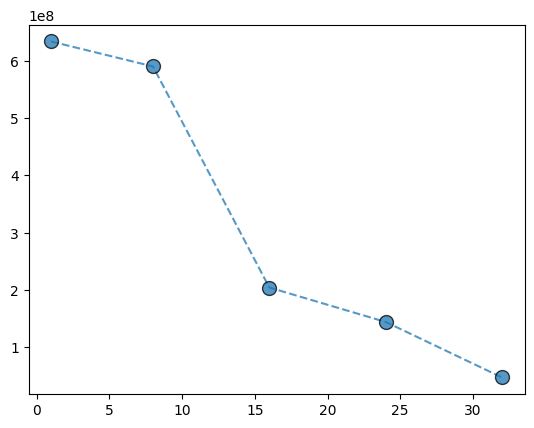

In [17]:
plt.plot(kvals, all_shots, "--o", mec="black", ms=10, alpha=0.75);
plt.savefig(f"metaphosphate_shots_for_chemical_accuracy_vs_k.pdf")

## SQD counts

In [17]:
from joblib import Parallel, delayed

In [18]:
all_sampled = []

In [19]:
def task(nshots=100_000):
    return [bitstring for bitstring, _ in psi.sample(int(nshots))]

In [20]:
results = []

In [68]:
for i in range(10):
    print("Status:", i + 1)
    results.extend(Parallel(n_jobs=20)(delayed(task)() for _ in range(10)))

Status: 1


/home/ryan/prof/work/wellcome/kcommute/envkcommute3/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(
/home/ryan/prof/work/wellcome/kcommute/envkcommute3/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(
/home/ryan/prof/work/wellcome/kcommute/envkcommute3/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one 

Status: 2
Status: 3
Status: 4
Status: 5
Status: 6
Status: 7
Status: 8
Status: 9
Status: 10


In [69]:
len(results)

300

In [70]:
sampled = [bitstring for result in results for bitstring in result]
len(sampled)

30000000

In [71]:
bit_array = qiskit.primitives.BitArray.from_bool_array(
    np.array(sampled[:], dtype=bool)
)

In [72]:
bit_array

BitArray(<shape=(), num_shots=30000000, num_bits=32>)

In [73]:
from functools import partial

from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

# SQD options
energy_tol = 1e-3
occupancies_tol = 1e-3
max_iterations = 32

# Eigenstate solver options
num_batches = 1
samples_per_batch = 300
symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200

# Pass options to the built-in eigensolver. If you just want to use the defaults,
# you can omit this step, in which case you would not specify the sci_solver argument
# in the call to diagonalize_fermionic_hamiltonian below.
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

# List to capture intermediate results
result_history = []


def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")


result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    bit_array,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=1,
)

Iteration 1
	Subsample 0
		Energy: -103.94088962770647
		Subspace dimension: 64516
Iteration 2
	Subsample 0
		Energy: -106.2345370196633
		Subspace dimension: 67081
Iteration 3
	Subsample 0
		Energy: -106.65023184152912
		Subspace dimension: 80089
Iteration 4
	Subsample 0
		Energy: -106.6594366515595
		Subspace dimension: 93025
Iteration 5
	Subsample 0
		Energy: -106.67457183971017
		Subspace dimension: 113569
Iteration 6
	Subsample 0
		Energy: -106.68349276941633
		Subspace dimension: 127449
Iteration 7
	Subsample 0
		Energy: -108.8534770605523
		Subspace dimension: 149769
Iteration 8
	Subsample 0
		Energy: -108.86847647343475
		Subspace dimension: 109561
Iteration 9
	Subsample 0
		Energy: -108.87663918394057
		Subspace dimension: 135424
Iteration 10
	Subsample 0
		Energy: -108.87973738599702
		Subspace dimension: 138384
Iteration 11
	Subsample 0
		Energy: -108.88693814186246
		Subspace dimension: 145924
Iteration 12
	Subsample 0
		Energy: -108.89353838458183
		Subspace dimension: 167

In [74]:
bit_array.num_shots

30000000

Exact energy: -109.04667 Ha
SQD energy: -108.89626 Ha
Absolute error: 0.15041 Ha


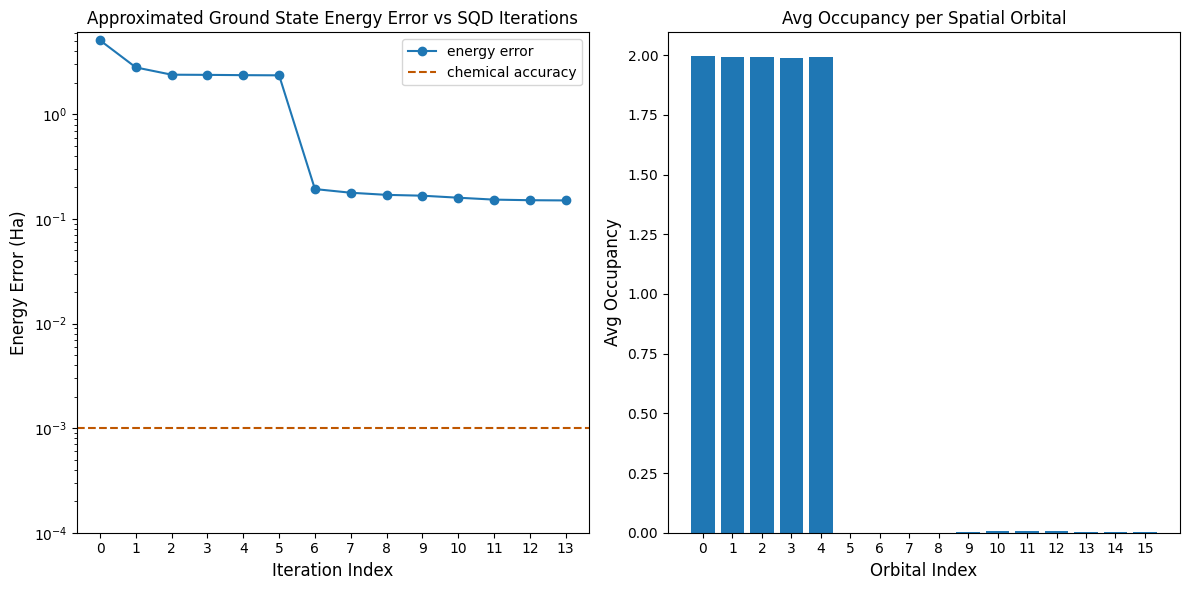

In [76]:
import matplotlib.pyplot as plt

# Data for energies plot
x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
e_diff = [abs(e - exact_energy) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

print(f"Exact energy: {exact_energy:.5f} Ha")
print(f"SQD energy: {min_e[-1]:.5f} Ha")
print(f"Absolute error: {e_diff[-1]:.5f} Ha")
plt.tight_layout()
plt.savefig(f"sqd_shots_{bit_array.num_shots}_max_iterations_{max_iterations}.pdf")